In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob
import os
import string
import plotly.express as px
from pathlib import Path
from datetime import datetime
from babel.dates import format_datetime
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from mpstemmer import MPStemmer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
import nltk
import gensim
from gensim.models import CoherenceModel
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
import gensim.corpora as corpora
import calendar
from nltk.util import ngrams
from nltk.util import bigrams
from nltk.util import trigrams
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.phrases import Phrases, Phraser
from collections import Counter
import pyLDAvis.gensim_models as gensimvis

In [14]:
import pandas as pd
import numpy as np

import pickle as pk

import warnings
warnings.filterwarnings("ignore")


from bs4 import BeautifulSoup
import unicodedata
import re

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from nltk.corpus import stopwords


from nltk.corpus import wordnet
from nltk import pos_tag
from nltk import ne_chunk

from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from wordcloud import WordCloud

**Our objective here to create a models that able to classified a topic to data we collect from scrapping, here are the possible sequence on what we should do:**

* Text Preprocessing : this include cleaning the dataset from noise such as punctuation, stop words, as well doing stemming or lemmatization to the text

* Bag of words : process of creating a dictionary of unique words from the corpus and unique integer IDs that are used to represent those words in the LDA model. 

* Corpus : involves creating a list of bag-of-words vectors, where each vector corresponds to a document in the corpus. 

* Train the models : here we using LDA to generate our models

* Evaluate : which include understanding what topics able to tell us if there is meaning in it, usually evaluating the quality of the topics extracted, using metrics by using Coherence or perplexity technique

* Inference : applied the models to the inference dataset

# Import dataset

In [15]:
path = 'C:/Users/WINDOWS 10/Documents/Skripsi/scrapingFIX' #/FIXCSV
li = []

for file in Path(path + '/FIXCSV').glob('*.csv'):
    li.append(pd.read_csv(file))

df = pd.concat(li, axis=0, ignore_index=True)

In [16]:
df_train = df.copy()

In [17]:
df_train['tahun'] = df_train['date'].str.split().str[-1]

In [18]:
df_train['bulan'] = df_train['date'].str.split().str[1]

# Create Text Prepocessing Function

### Stemmer

In [19]:
stemmer = StemmerFactory().create_stemmer()
stemmer2 = MPStemmer()

### Stopword 

NLTK

In [77]:
#add newstopword
stopword = stopwords.words('indonesian')
more_stopword = ['dok','dokter','selamat','halo','hallo','hi','alodokter',
                 'tadi','terus','nya','lalu','apa','jadi','bahkan','iya',
                 'kira','terimakasih','Dokter','Dok', 'langsung ',
                 'minggu', 'malam', 'siang', 'kali', 'sebab','alami', 
                 'pagi','kadang','mohon', 'terima','kasih','siang','sore','malam','pagi','alo','apa','semalam',
                 'tanggal','umur','tahun','bulan','hari','jam','minggu','kali','kemarin','kemaren','kemarinnya','kemarennya'
                 ,'apa']
stopword.extend(more_stopword)
not_stopword = {'capek','dpt'}
#fix stopword
fin_stp = set([word for word in stopword if word not in not_stopword])

In [21]:
# sastrawi stopword
stop_word2 = StopWordRemoverFactory()
data_stp2 = stop_word2.get_stop_words() + more_stopword

In [22]:
data_stp2.remove('tidak')
data_stp2.remove('ya')

In [23]:
final_stopword2 = StopWordRemover(ArrayDictionary(data_stp2))

### Slang ke baku

In [24]:
#slang word
baku = pd.read_csv(path + '/baku/baku[ori].csv')

std_word_replace = {}
for i, row in enumerate(baku['slang']):
    std_word_replace[row] = baku['baku'].iloc[i]

## Function

In [25]:
from gensim.utils import tokenize

## trial&error

# 2018

## EDA

In [26]:
df_2018 = df_train[df_train['tahun'] == '2018'].reset_index(drop=True)

In [27]:
#map for datetime format
bulan_map = {'Januari': 1, 'Februari': 2, 'Maret': 3, 'April': 4, 'Mei': 5, 'Juni': 6, 'Juli': 7, 'Agustus': 8, 'September': 9, 'Oktober': 10, 'November': 11, 'Desember': 12}
df_2018['bulan'] = df_2018['bulan'].map(bulan_map)

In [28]:
# datetime format
order_month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_2018['bulan'] = df_2018['bulan'].apply(lambda x: calendar.month_name[x])
df_2018['bulan'] = pd.Categorical(df_2018['bulan'], categories=order_month, ordered=True)

In [29]:
#explore the data
c18 = df_2018.groupby(by=['bulan']).size().reset_index(name='jumlah')
fig18 = px.line(c18, x='bulan', y='jumlah', title='Jumlah Keluhan Kesehatan Tahun 2018', markers=True)
fig18.update_layout(xaxis_title='Bulan', yaxis_title='Total', plot_bgcolor="white")
fig18.update_xaxes(tickangle=45)
fig18.update_yaxes(tickformat=',d')
fig18.show()

## Text Preprocessing

In [30]:
df_2018.isnull().sum()

title        0
question     3
user_name    4
user_type    0
date         0
link         0
tahun        0
bulan        0
dtype: int64

In [31]:
df_2018 = df_2018.dropna().reset_index(drop=True)

In [78]:
#training section
df_train18 = df_2018[['title', 'question']]

### Corpus normalization

In [33]:
#cleaning method

def remove_punct(text):
    if isinstance(text, float):
        return text
    text = text.lower()

    #remove punctuation
    text = text.replace(',', ' ')
    text = re.sub(r'[{}]'.format(string.punctuation + '\n'), ' ', text)
    text = ''.join('' if a in string.punctuation else a for a in text)
    return text

def dok_word(text):
    text = remove_punct(text)
    split_dok = text.split()
    for i, word in enumerate(split_dok):
        if word.startswith('dok') and len(word) > 3:
            split_dok[i] = 'dok' + word.replace('dok', '', 1)
    text = " ".join(split_dok)
    return text

def normalization(text):
    text = dok_word(text)
    temp_list = []
    temp_normalization = text.split()
    for i in temp_normalization:
        if i not in std_word_replace:
            temp_list.append(i)
        elif i in std_word_replace:
            temp_list += std_word_replace[i].split()
    temp_list = ' '.join(text for text in temp_list if text not in fin_stp)
    return temp_list

def token_funct(text):
    text = normalization(text)
    token = tokenize(text)
    token_text = list(token)
    return token_text

In [34]:
df_train18['clean'] = df_train18['question'].apply(lambda x: token_funct(x))

In [35]:
df_train18['clean'][32234]

['anak',
 'usia',
 'mengalami',
 'cacar',
 'air',
 'doksudah',
 'bintik',
 'muncul',
 'penanganan',
 'mempercepat',
 'sembuh',
 'dbawa',
 'rumah',
 'sakit',
 'penderita',
 'cacar',
 'air',
 'anak',
 'air',
 'kelapa',
 'ijo',
 'mandi',
 'air',
 'dcampur',
 'antiseptic',
 'bilang',
 'cacar',
 'air',
 'mandi']

### n-gram


In [36]:
def make_bigrams(texts): #fungsi untuk membuat bigram
    bigram = gensim.models.Phrases(texts, min_count=9, threshold=8) #hyperparameter untuk penentuan bobot perkata
    bigram_mod = gensim.models.phrases.Phraser(bigram) #pembentukan model
    return [bigram_mod[doc] for doc in texts] #hasil kata-kata yang tercipta menggunakan model

def trigram_func(texts): #fungsi untuk membuat trigram
    bigram = gensim.models.Phrases(texts, min_count=9, threshold=5)
    trigram = gensim.models.Phrases(bigram[texts], min_count = 15, threshold=2.5)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    return [trigram_mod[doc] for doc in texts]

In [37]:
bigrams18 = make_bigrams(df_train18['clean'])
trigrams18 = trigram_func(df_train18['clean'])

#### use it when needed

In [38]:
token_toremove = ['terima_kasih','kasih','sebab',
                  'terima','tanggal','hari','teman',
                  'bulan','kah', 'maaf','trimakasih',
                  'assalamualaikum', 'jelas_terima', 
                  'atas_terima', 'hello', 'ku', 'doc', 
                  'trimakasi', 'trkadang', 'skrg', 
                  'jelas','cek', 'kemarin', 'apakh', 
                  'sok', 'tanya', 'ig', 'cerita', 'biar', 
                  'pakai', 'laku', 'saran', 'ada', 'nomor', 
                  'sih', 'suka', 'selsai', 'minggu', 'tunggu', 
                  'keluar', 'solusi', 'alami', 'apa', 'tolong', 'kena',
                  'salah', 'orang', 'beda', 'coba', 'batch', 
                  'amadeo_basfiansa', 'ianya', 
                  'dlakukan', 'maksud', 'kesan', 'deh', 'and', 
                  'tanyak', 'nak', 'nyri', 'ubat', 'rana', 'aqua',
                  'assalamu_alaikum', 'hai_brtanya', 'gara', 'uk', 'terima_kasih_kasih', 
                  'smacam', 'nama', 'now_watching', 'tolong_solusi_terima_kasih','tgl',
                  'atas_terima_kasih','ass','tolong_jelas','tolong_jelas','nanyak',
                  'wass', 'jawabanya_terima_kasih', 'doctor', 'doktor', 'hai', 'terimakasi', 
                  'misi', 'kemarin_habis', 'tnykn', 'dokk', 'hai_doktor', 'berak_dokk', 'jam', 
                  'sore', 'umur' ,'sakit', 'sembuh', 'usia', 'kayak', 'knapa', 'terima_kasih_sukses', 
                  'sekian_terima_kasih', 'umur_alami', 'assalamu_alaikum_nama', 'ter',
                  'ter_bedah','apa','tanggal']
for i, doc in enumerate(trigrams18):
    trigrams18[i] = [token for token in doc if token != token_toremove]

In [39]:
filtered_token = [[token for token in doc if token not in token_toremove] for doc in trigrams18]

In [40]:
from collections import Counter

bigrams = [bigram for doc in bigrams18 for bigram in doc if '_' in bigram]
trigrams = [trigram for doc in trigrams18 for trigram in doc if '_' in trigram]

def visualize_frequent_words(tokens_list, num_words):
    # Count the frequency of each token
    word_freq = Counter(tokens_list)
    
    # Get the most frequent words
    top_words = word_freq.most_common(num_words)
    
    # Extract the words and their counts
    words = [w[0] for w in top_words]
    counts = [w[1] for w in top_words]
    
    # Create a bar chart of the word frequencies
    plt.bar(words, counts)
    plt.xticks(rotation=90)
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.title('Top {} Most Frequent Words'.format(num_words))
    plt.show()

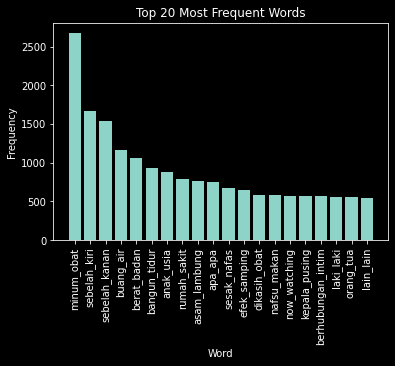

In [41]:
visualize_frequent_words(bigrams, 20)

### Most Frequent word

In [42]:
# check removed token
word_freq19 = Counter([item for sublist in filtered_token for item in sublist])
word_freq19.most_common(10)

[('anak', 6884),
 ('obat', 6390),
 ('normal', 4729),
 ('penyakit', 3911),
 ('hamil', 3816),
 ('nyeri', 3726),
 ('mengalami', 3580),
 ('haid', 3493),
 ('gatal', 3385),
 ('darah', 3254)]

In [43]:
#check most frequent words
all_words = [word for tokens in df_train18['clean'] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df_train18['clean']]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

1216892 words total, with a vocabulary size of 55917
Max sentence length is 570


In [44]:
word_freq = Counter(all_words)
word_freq.most_common(10)

[('sakit', 24281),
 ('obat', 15498),
 ('anak', 11370),
 ('minum', 8501),
 ('darah', 8278),
 ('mengalami', 7909),
 ('haid', 7261),
 ('perut', 7132),
 ('nyeri', 6810),
 ('penyakit', 6796)]

## Dictionary from the corpus

## Create corpus to input to the models

In [45]:
#create dict
dictionary18 = corpora.Dictionary(filtered_token)
#create corpus
texts = filtered_token
corpus18 = [dictionary18.doc2bow(text) for text in texts]

## Train the models

here a possible sequence that we use to create a models which include checking how good the modesl is by addapting coherence value inside of the function

In [46]:
import multiprocessing

print(f"Number of CPU cores: {multiprocessing.cpu_count()}")

Number of CPU cores: 8


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list1 = []

    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics, 
                        random_state=42,
                        chunksize=5,
                        passes=20,
                        update_every=5,
                        alpha=0.3,
                        eta=0.8,
                        decay=0.8,
                        iterations=150,
                        minimum_probability=0.65,
                        per_word_topics=True) 
        model_list1.append(model) 
        #check the coherence value
        coherencemodel = CoherenceModel(model=model, 
                                        texts=texts,
                                        dictionary=dictionary, 
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

        #check the preplexity
        perplexity = model.log_perplexity(corpus)

    return model_list1, coherence_values, perplexity

It is important that changing the hyperparameters can have trade-offs. Increasing alpha can lead to more diverse topics, but it can also increase the noise in the topics. Decreasing eta can lead to more diverse words within topics, but it can also lead to more similar topics. Therefore, it is recommended to try different values of hyperparameters and evaluate the resulting topics based on coherence and interpretability.

In [ ]:
model_list, coherence_values, preplexity = compute_coherence_values(dictionary=dictionary18, corpus=corpus18, texts=filtered_token, start=2, limit=15, step=2) 

In [ ]:
# show graph
limit=15; start=2; step=2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
best_model = model_list[np.argmax(coherence_values)]
best_model.print_topics()

In [ ]:
vis = gensimvis.prepare(best_model, corpus18, dictionary18)
pyLDAvis.display(vis)

In [ ]:
#show perplexity
print(f"Perplexity: {best_model.log_perplexity(corpus18)}")

In [ ]:
import math
nbound = np.exp2(best_model.log_perplexity(corpus18))
print(f"Perplexity: {nbound}")

In [48]:
from flair.models import SequenceTagger

In [49]:
import torch

folder_path = "C:/Users/WINDOWS 10/Documents/Skripsi/scrapingFIX/indonesia-bioner"
model_state = torch.load(f"{folder_path}/pytorch_model.bin", map_location=torch.device('cpu'))

In [89]:
from flair.models import SequenceTagger


tagger = SequenceTagger.load("abid/indonesia-bioner")

2023-05-10 18:25:23,363 SequenceTagger predicts: Dictionary with 9 tags: O, S-DISO, B-DISO, E-DISO, I-DISO, S-ANAT, B-ANAT, E-ANAT, I-ANAT


In [51]:
from flair.data import Sentence

sentence = Sentence('Presiden Jokowi akan mengunjungi Yogyakarta minggu depan')

In [52]:
tagger.predict(sentence)

In [53]:
print(sentence.to_tagged_string())

Sentence[7]: "Presiden Jokowi akan mengunjungi Yogyakarta minggu depan"


In [54]:
# iterate over the predicted named entities
for entity in sentence.get_spans('ner'):
    # get the entity type (label)
    label = entity.get_labels()[0].value
    print(f'{entity.text}: {label}')

In [55]:
def tag_ner(text):
    sentence = Sentence(text)
    tagger.predict(sentence)
    return sentence.to_tagged_string()

In [56]:
df_train18['ner'] = df_train18['clean'].apply(lambda x: tag_ner(x))

2023-05-09 07:09:05,248 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-05-09 07:13:57,057 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-05-09 07:23:19,180 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-05-09 07:25:49,384 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-05-09 07:29:20,176 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-05-09 07:52:47,756 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-05-09 07:57:25,619 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-05-09 07:59:07,700 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-05-09 08:21:48,832 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-05-09 08:25:27,781 Warning: An empty Sentence was 

In [79]:
df_train18['no_token'] = df_train18['question'].apply(lambda x: normalization(x))

In [69]:
df_train18['ner_no_token'] = df_train18['no_token'].apply(lambda x: tag_ner(x))

In [71]:
df_train18['ner_no_token'][213]

'Sentence[34]: "sentence 25 teman menderita epilepsi kelas sembuh total umurnya pengobatan sembuh total medis non medis trapi ruqyah bekam obat an dironsen kepalanya obat mujarab sembuhi total jwbnnya → epilepsi diso ruqyah diso bekam diso" → ["epilepsi"/DISO, "ruqyah"/DISO, "bekam"/DISO, "epilepsi"/DISO, "diso"/DISO, "ruqyah"/DISO, "diso"/DISO, "bekam"/DISO, "diso"/DISO]'

In [85]:
df_train18['question'][213]

'siang dok,saya ingin bertanya,ada tmn saya menderita epilepsi sejak kelas 3 SMP sampai skrg tdk sembuh total,umurnya kira2 32 taun,sdh berbagai pengobatan tdk sembuh total,mau medis,non medis,trapi,ruqyah,bekam,obat2an.dironsen tdk mslh pd kepalanya.apa obat yg mujarab sembuhi total ya dok?? trims ya dok jwbnnya\n '

In [84]:
df_train18['no_token'][213]

'teman menderita epilepsi kelas 3 sembuh total umurnya 32 pengobatan sembuh total medis non medis trapi ruqyah bekam obat2an dironsen kepalanya obat mujarab sembuhi total jwbnnya'

In [83]:
df_train18['question'][5512]

'Dokter hari ini perut saya rasanya aneh sepertinya kembung, lalu saya tadi juga sudah bab tapi kok rasanya menjanggal diperut saya, akhirnya saya minum antangin sebelum minum antangin saya sudah makan pepaya, apa boleh dok seperti itu dan apa efeknya jika minum antangin sebelum makan nasi, terima kasih mohon jawaban dan bantuannya, dok'

In [91]:
# define the text to be analyzed
text = 'siang dok,saya ingin bertanya,ada tmn saya menderita epilepsi sejak kelas 3 SMP sampai skrg tdk sembuh total,umurnya kira2 32 taun,sdh berbagai pengobatan tdk sembuh total,mau medis,non medis,trapi,ruqyah,bekam,obat2an.dironsen tdk mslh pd kepalanya.apa obat yg mujarab sembuhi total ya dok?? trims ya dok jwbnnya\n '

# create a Flair sentence object
sentence = Sentence(text)

# predict the entities in the sentence
tagger.predict(sentence)

# create a list of tuples (entity_text, entity_type) for each entity
entities = [(entity.text, entity.labels[0].value) for entity in sentence.get_spans('ner')]

# filter the list to only include entities with type 'DISO'
diso_entities = [entity for entity in entities if entity[1] == 'DISO']

# print the list of DISO entities
print(diso_entities)

[('epilepsi', 'DISO')]
